In this notebook we are going to perform all the operations needed in order to obtain a dataset consisting of the residuals of each time series. The idea is that of performing anomaly detection also on the residuals, not only on the energy consumption values, and then find a way to put together the two results, in an ensemble (to be decided).

In [1]:
%cd /nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis

/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis


/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from preprocessing import *
import preprocessing as prp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose, MSTL

import warnings
warnings.filterwarnings('ignore')

We need to obtain the dataset. We are going to keep it like it is, with all the features, and perform all the preprocessing steps needed (imputation of missing values, of missing dates).

In [3]:
dataset = pd.read_csv("/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis/data/train.csv")
dataset.shape

(1749494, 57)

In [4]:
dataset = impute_nulls(dataset)

In [5]:
dataset

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag7,air_temperature_max_lag7,air_temperature_min_lag7,air_temperature_std_lag7,air_temperature_mean_lag73,air_temperature_max_lag73,air_temperature_min_lag73,air_temperature_std_lag73,hour,weekday,month,year,weekday_hour,hour_x,hour_y,month_x,month_y,weekday_x,weekday_y,building_weekday_hour,building_weekday,building_month,building_hour,building_meter,is_holiday,gte_hour,gte_weekday,gte_month,gte_building_id,gte_primary_use,gte_site_id,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,1,2016-01-01 00:00:00,31.477940,0,0,Education,2720,104,0,19.4,255,19.4,0,967.2,0,0.0,20.875,22.297,19.578,1.070,21.516,27.797,16.125,3.607,0,4,1,2016,4-0,1.000,0.000,1.000,0.000,1.000,0.000,1-0-4-0,1-0-4,1-0-1,1-0-0,1-0-,1,4.189,4.380,4.351,3.569,4.615,4.703,4.116,3.981,4.146,4.120,3.569,4.489,4.079,3.554,3.538,3.845
200,1,2016-01-01 01:00:00,29.582970,0,0,Education,2720,104,0,21.1,6,21.1,-1,1019.4,0,0.0,20.625,21.094,19.578,0.683,21.484,27.797,16.156,3.566,1,4,1,2016,4-1,0.966,0.259,1.000,0.009,0.999,0.037,1-0-4-1,1-0-4,1-0-1,1-0-1,1-0-,1,4.161,4.380,4.351,3.569,4.615,4.703,4.116,3.964,4.146,4.120,3.569,4.489,4.079,3.553,3.538,3.845
398,1,2016-01-01 02:00:00,28.635485,0,0,Education,2720,104,0,21.1,255,21.1,0,1018.8,210,1.5,20.625,21.094,19.578,0.683,21.500,27.797,16.188,3.525,2,4,1,2016,4-2,0.866,0.500,1.000,0.017,0.997,0.075,1-0-4-2,1-0-4,1-0-1,1-0-2,1-0-,1,4.148,4.380,4.351,3.569,4.615,4.703,4.116,3.952,4.146,4.120,3.569,4.489,4.079,3.549,3.538,3.845
597,1,2016-01-01 03:00:00,28.161742,0,0,Education,2720,104,0,20.6,255,20.0,0,1018.1,0,0.0,20.719,21.094,19.766,0.625,21.531,27.797,16.219,3.490,3,4,1,2016,4-3,0.707,0.707,1.000,0.026,0.994,0.112,1-0-4-3,1-0-4,1-0-1,1-0-3,1-0-,1,4.132,4.380,4.351,3.569,4.615,4.703,4.116,3.942,4.146,4.120,3.569,4.489,4.079,3.543,3.538,3.845
796,1,2016-01-01 04:00:00,27.924871,0,0,Education,2720,104,0,21.1,255,20.6,0,1019.0,290,1.5,20.641,21.094,19.406,0.804,21.531,27.797,16.250,3.453,4,4,1,2016,4-4,0.500,0.866,0.999,0.034,0.989,0.149,1-0-4-4,1-0-4,1-0-1,1-0-4,1-0-,1,4.128,4.380,4.351,3.569,4.615,4.703,4.116,3.943,4.146,4.120,3.569,4.489,4.079,3.542,3.538,3.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1748693,1353,2016-12-31 19:00:00,2.425000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734,-1.000,-22.016,-18.562,-29.281,-0.481,19,5,12,2016,5-19,0.259,-0.966,0.979,0.204,-0.037,0.999,1353-0-5-19,1353-0-5,1353-0-12,1353-0-19,1353-0-,0,4.410,4.254,4.297,2.004,1.669,4.331,4.116,4.158,4.012,4.056,1.967,1.556,4.188,2.013,1.896,1.566
1748893,1353,2016-12-31 20:00:00,2.450000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734,-1.000,-22.016,-18.562,-29.281,-0.481,20,5,12,2016,5-20,0.500,-0.866,0.977,0.212,-0.075,0.997,1353-0-5-20,1353-0-5,1353-0-12,1353-0-20,1353-0-,0,4.384,4.254,4.297,2.004,1.669,4.331,4.116,4.137,4.012,4.056,1.967,1.556,4.188,2.063,1.896,1.566
1749093,1353,2016-12-31 21:00:00,2.425000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734,-1.000,-22.016,-18.562,-29.281,-0.481,21,5,12,2016,5-21,0.707,-0.707,0.975,0.220,-0.112,0.994,1353-0-5-21,1353-0-5,1353-0-12,1353-0-21,1353-0-,0,4.345,4.254,4.297,2.004,1.669,4.331,4.116,4.102,4.012,4.056,1.967,1.556,4.188,2.057,1.896,1.566
1749293,1353,2016-12-31 22:00:00,2.450000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734

In [7]:
dataset.timestamp = pd.to_datetime(dataset.timestamp)

In [8]:
dataframe = impute_missing_dates(dataset)

In [10]:
df1 = pd.concat(dataframe.values())
df1

,building_id,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag7,air_temperature_max_lag7,air_temperature_min_lag7,air_temperature_std_lag7,air_temperature_mean_lag73,air_temperature_max_lag73,air_temperature_min_lag73,air_temperature_std_lag73,hour,weekday,month,year,weekday_hour,hour_x,hour_y,month_x,month_y,weekday_x,weekday_y,building_weekday_hour,building_weekday,building_month,building_hour,building_meter,is_holiday,gte_hour,gte_weekday,gte_month,gte_building_id,gte_primary_use,gte_site_id,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
2016-01-01 00:00:00,1,31.477940,0,0,Education,2720,104,0,19.4,255,19.4,0,967.2,0,0.0,20.875,22.297,19.578,1.070,21.516,27.797,16.125,3.607,0,4,1,2016,4-0,1.000,0.000,1.000,0.000,1.000,0.000,1-0-4-0,1-0-4,1-0-1,1-0-0,1-0-,1,4.189,4.380,4.351,3.569,4.615,4.703,4.116,3.981,4.146,4.120,3.569,4.489,4.079,3.554,3.538,3.845
2016-01-01 01:00:00,1,29.582970,0,0,Education,2720,104,0,21.1,6,21.1,-1,1019.4,0,0.0,20.625,21.094,19.578,0.683,21.484,27.797,16.156,3.566,1,4,1,2016,4-1,0.966,0.259,1.000,0.009,0.999,0.037,1-0-4-1,1-0-4,1-0-1,1-0-1,1-0-,1,4.161,4.380,4.351,3.569,4.615,4.703,4.116,3.964,4.146,4.120,3.569,4.489,4.079,3.553,3.538,3.845
2016-01-01 02:00:00,1,28.635485,0,0,Education,2720,104,0,21.1,255,21.1,0,1018.8,210,1.5,20.625,21.094,19.578,0.683,21.500,27.797,16.188,3.525,2,4,1,2016,4-2,0.866,0.500,1.000,0.017,0.997,0.075,1-0-4-2,1-0-4,1-0-1,1-0-2,1-0-,1,4.148,4.380,4.351,3.569,4.615,4.703,4.116,3.952,4.146,4.120,3.569,4.489,4.079,3.549,3.538,3.845
2016-01-01 03:00:00,1,28.161742,0,0,Education,2720,104,0,20.6,255,20.0,0,1018.1,0,0.0,20.719,21.094,19.766,0.625,21.531,27.797,16.219,3.490,3,4,1,2016,4-3,0.707,0.707,1.000,0.026,0.994,0.112,1-0-4-3,1-0-4,1-0-1,1-0-3,1-0-,1,4.132,4.380,4.351,3.569,4.615,4.703,4.116,3.942,4.146,4.120,3.569,4.489,4.079,3.543,3.538,3.845
2016-01-01 04:00:00,1,27.924871,0,0,Education,2720,104,0,21.1,255,20.6,0,1019.0,290,1.5,20.641,21.094,19.406,0.804,21.531,27.797,16.250,3.453,4,4,1,2016,4-4,0.500,0.866,0.999,0.034,0.989,0.149,1-0-4-4,1-0-4,1-0-1,1-0-4,1-0-,1,4.128,4.380,4.351,3.569,4.615,4.703,4.116,3.943,4.146,4.120,3.569,4.489,4.079,3.542,3.538,3.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1353,2.425000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734,-1.000,-22.016,-18.562,-29.281,-0.481,19,5,12,2016,5-19,0.259,-0.966,0.979,0.204,-0.037,0.999,1353-0-5-19,1353-0-5,1353-0-12,1353-0-19,1353-0-,0,4.410,4.254,4.297,2.004,1.669,4.331,4.116,4.158,4.012,4.056,1.967,1.556,4.188,2.013,1.896,1.566
2016-12-31 20:00:00,1353,2.450000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734,-1.000,-22.016,-18.562,-29.281,-0.481,20,5,12,2016,5-20,0.500,-0.866,0.977,0.212,-0.075,0.997,1353-0-5-20,1353-0-5,1353-0-12,1353-0-20,1353-0-,0,4.384,4.254,4.297,2.004,1.669,4.331,4.116,4.137,4.012,4.056,1.967,1.556,4.188,2.063,1.896,1.566
2016-12-31 21:00:00,1353,2.425000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734,-1.000,-22.016,-18.562,-29.281,-0.481,21,5,12,2016,5-21,0.707,-0.707,0.975,0.220,-0.112,0.994,1353-0-5-21,1353-0-5,1353-0-12,1353-0-21,1353-0-,0,4.345,4.254,4.297,2.004,1.669,4.331,4.116,4.102,4.012,4.056,1.967,1.556,4.188,2.057,1.896,1.566
2016-12-31 22:00:00,1353,2.450000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734,-1.000,-22.016,-18.562,-29.281,-0.481,22,5,12,2016,5-22,0.866,-

Now that we have imputed the missing timestamps and missing dates, we can proceed with performing the decomposition for all the time series present in the dataset.

In [11]:
df1.building_id.unique()

array([   1,   32,   41,   55,   69,   79,   82,   91,  107,  108,  111,
        112,  117,  118,  119,  121,  136,  137,  139,  141,  144,  147,
        148,  149,  159,  171,  173,  174,  181,  183,  190,  235,  238,
        240,  246,  247,  248,  253,  254,  263,  270,  275,  276,  278,
        290,  293,  312,  318,  335,  345,  356,  423,  439,  492,  534,
        560,  623,  653,  657,  658,  666,  667,  673,  675,  677,  680,
        683,  685,  687,  693,  697,  698,  701,  708,  710,  721,  722,
        729,  730,  732,  739,  742,  801,  827,  844,  848,  879,  880,
        881,  882,  884,  886,  887,  889,  890,  892,  893,  894,  895,
        896,  903,  905,  909,  914,  919,  922,  924,  925,  926,  928,
        929,  931,  935,  936,  941,  942,  945,  948,  950,  952,  961,
        966,  967,  968,  969,  970,  971,  973,  974,  975,  977,  978,
        981,  988,  990,  992,  994,  996, 1001, 1007, 1068, 1073, 1074,
       1106, 1120, 1128, 1137, 1141, 1143, 1147, 11

In [36]:
time_series = df1[df1.building_id == 801]
true_anomalies = time_series.loc[time_series['anomaly'] == 1]

In [37]:
series = time_series[['meter_reading']]

In [38]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=series.index, y=series['meter_reading'], name='Energy consumption'))
fig.add_trace(go.Scatter(x=true_anomalies.index, y=true_anomalies['meter_reading'], mode='markers', marker=dict(color='coral'), name='Anomalies'))
fig.update_layout(showlegend=True, font_size = 15, legend=dict(x = 0, y = 1.2))
fig.show()

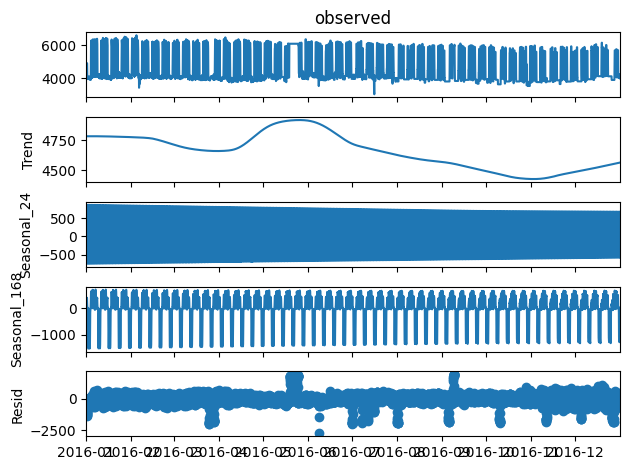

In [39]:
mstl = MSTL(series, periods = [24, 24*7], windows = [len(series) + 1 , len(series) + 1], iterate = 3, stl_kwargs={ "trend": 24*7*13 + 1, "seasonal_deg": 1})
res = mstl.fit()
res.plot()
plt.tight_layout()
plt.show()

In [40]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=res.resid.index, y=res.resid, name='Residual Energy consumption'))
fig.add_trace(go.Scatter(x=true_anomalies.index, y=res.resid[true_anomalies.index], mode='markers', marker=dict(color='coral'), name='Anomalies'))
fig.update_layout(showlegend=True, font_size = 15, legend=dict(x = 0, y = 1.2))
fig.show()

In [21]:
dict_resid = {}
for building_id, gdf in df1.groupby('building_id'):
    serie = gdf.meter_reading
    mstl = MSTL(serie, periods = [24, 24*7], windows = [len(series) + 1 , len(series) + 1], iterate = 3, stl_kwargs={ "trend": 24*7*13 + 1, "seasonal_deg": 1})
    res = mstl.fit()
    residual = res.resid
    dict_resid[building_id] = residual
df_resid = pd.concat(dict_resid.values())

In [22]:
df_resid

2016-01-01 00:00:00    1.896671
2016-01-01 01:00:00    0.190768
2016-01-01 02:00:00   -0.794366
2016-01-01 03:00:00   -1.632265
2016-01-01 04:00:00   -2.043640
                         ...   
2016-12-31 19:00:00   -2.596513
2016-12-31 20:00:00   -2.969752
2016-12-31 21:00:00   -1.357702
2016-12-31 22:00:00   -0.367817
2016-12-31 23:00:00    1.848508
Name: resid, Length: 1756800, dtype: float64

In [25]:
concatenazione = pd.concat([df1, df_resid], axis=1)

In [35]:
concatenazione

,building_id,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag7,air_temperature_max_lag7,air_temperature_min_lag7,air_temperature_std_lag7,air_temperature_mean_lag73,air_temperature_max_lag73,air_temperature_min_lag73,air_temperature_std_lag73,hour,weekday,month,year,weekday_hour,hour_x,hour_y,month_x,month_y,weekday_x,weekday_y,building_weekday_hour,building_weekday,building_month,building_hour,building_meter,is_holiday,gte_hour,gte_weekday,gte_month,gte_building_id,gte_primary_use,gte_site_id,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month,resid
2016-01-01 00:00:00,1,31.477940,0,0,Education,2720,104,0,19.4,255,19.4,0,967.2,0,0.0,20.875,22.297,19.578,1.070,21.516,27.797,16.125,3.607,0,4,1,2016,4-0,1.000,0.000,1.000,0.000,1.000,0.000,1-0-4-0,1-0-4,1-0-1,1-0-0,1-0-,1,4.189,4.380,4.351,3.569,4.615,4.703,4.116,3.981,4.146,4.120,3.569,4.489,4.079,3.554,3.538,3.845,1.896671
2016-01-01 01:00:00,1,29.582970,0,0,Education,2720,104,0,21.1,6,21.1,-1,1019.4,0,0.0,20.625,21.094,19.578,0.683,21.484,27.797,16.156,3.566,1,4,1,2016,4-1,0.966,0.259,1.000,0.009,0.999,0.037,1-0-4-1,1-0-4,1-0-1,1-0-1,1-0-,1,4.161,4.380,4.351,3.569,4.615,4.703,4.116,3.964,4.146,4.120,3.569,4.489,4.079,3.553,3.538,3.845,0.190768
2016-01-01 02:00:00,1,28.635485,0,0,Education,2720,104,0,21.1,255,21.1,0,1018.8,210,1.5,20.625,21.094,19.578,0.683,21.500,27.797,16.188,3.525,2,4,1,2016,4-2,0.866,0.500,1.000,0.017,0.997,0.075,1-0-4-2,1-0-4,1-0-1,1-0-2,1-0-,1,4.148,4.380,4.351,3.569,4.615,4.703,4.116,3.952,4.146,4.120,3.569,4.489,4.079,3.549,3.538,3.845,-0.794366
2016-01-01 03:00:00,1,28.161742,0,0,Education,2720,104,0,20.6,255,20.0,0,1018.1,0,0.0,20.719,21.094,19.766,0.625,21.531,27.797,16.219,3.490,3,4,1,2016,4-3,0.707,0.707,1.000,0.026,0.994,0.112,1-0-4-3,1-0-4,1-0-1,1-0-3,1-0-,1,4.132,4.380,4.351,3.569,4.615,4.703,4.116,3.942,4.146,4.120,3.569,4.489,4.079,3.543,3.538,3.845,-1.632265
2016-01-01 04:00:00,1,27.924871,0,0,Education,2720,104,0,21.1,255,20.6,0,1019.0,290,1.5,20.641,21.094,19.406,0.804,21.531,27.797,16.250,3.453,4,4,1,2016,4-4,0.500,0.866,0.999,0.034,0.989,0.149,1-0-4-4,1-0-4,1-0-1,1-0-4,1-0-,1,4.128,4.380,4.351,3.569,4.615,4.703,4.116,3.943,4.146,4.120,3.569,4.489,4.079,3.542,3.538,3.845,-2.043640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1353,2.425000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734,-1.000,-22.016,-18.562,-29.281,-0.481,19,5,12,2016,5-19,0.259,-0.966,0.979,0.204,-0.037,0.999,1353-0-5-19,1353-0-5,1353-0-12,1353-0-19,1353-0-,0,4.410,4.254,4.297,2.004,1.669,4.331,4.116,4.158,4.012,4.056,1.967,1.556,4.188,2.013,1.896,1.566,-2.596513
2016-12-31 20:00:00,1353,2.450000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734,-1.000,-22.016,-18.562,-29.281,-0.481,20,5,12,2016,5-20,0.500,-0.866,0.977,0.212,-0.075,0.997,1353-0-5-20,1353-0-5,1353-0-12,1353-0-20,1353-0-,0,4.384,4.254,4.297,2.004,1.669,4.331,4.116,4.137,4.012,4.056,1.967,1.556,4.188,2.063,1.896,1.566,-2.969752
2016-12-31 21:00:00,1353,2.425000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734,-1.000,-22.016,-18.562,-29.281,-0.481,21,5,12,2016,5-21,0.707,-0.707,0.975,0.220,-0.112,0.994,1353-0-5-21,1353-0-5,1353-0-12,1353-0-21,1353-0-,0,4.345,4.254,4.297,2.004,1.669,4.331,4.116,4.102,4.012,4.056,1.967,1.556,4.188,2.057,1.896,1.566,-1.357702
2016-12-31 22:00:00,1353,2.450000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0

In [43]:
serien = concatenazione[concatenazione.building_id == 801]
anomalies = serien.loc[serien['anomaly'] == 1]

In [46]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=serien.index, y=serien.meter_reading, name='Energy consumption'))
fig.add_trace(go.Scatter(x=anomalies.index, y=serien.meter_reading[anomalies.index], mode='markers', marker=dict(color='coral'), name='Anomalies'))
fig.add_trace(go.Scatter(x=serien.index, y=serien.resid, name='Residual Energy consumption'))
fig.add_trace(go.Scatter(x=anomalies.index, y=serien.resid[anomalies.index], mode='markers', marker=dict(color='coral'), name='Anomalies'))
fig.update_layout(showlegend=True)
fig.show()

In [48]:
concatenazione.reset_index(drop = False, names = ['timestamp'], inplace = True)

In [49]:
concatenazione

,timestamp,building_id,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag7,air_temperature_max_lag7,air_temperature_min_lag7,air_temperature_std_lag7,air_temperature_mean_lag73,air_temperature_max_lag73,air_temperature_min_lag73,air_temperature_std_lag73,hour,weekday,month,year,weekday_hour,hour_x,hour_y,month_x,month_y,weekday_x,weekday_y,building_weekday_hour,building_weekday,building_month,building_hour,building_meter,is_holiday,gte_hour,gte_weekday,gte_month,gte_building_id,gte_primary_use,gte_site_id,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month,resid
0,2016-01-01 00:00:00,1,31.477940,0,0,Education,2720,104,0,19.4,255,19.4,0,967.2,0,0.0,20.875,22.297,19.578,1.070,21.516,27.797,16.125,3.607,0,4,1,2016,4-0,1.000,0.000,1.000,0.000,1.000,0.000,1-0-4-0,1-0-4,1-0-1,1-0-0,1-0-,1,4.189,4.380,4.351,3.569,4.615,4.703,4.116,3.981,4.146,4.120,3.569,4.489,4.079,3.554,3.538,3.845,1.896671
1,2016-01-01 01:00:00,1,29.582970,0,0,Education,2720,104,0,21.1,6,21.1,-1,1019.4,0,0.0,20.625,21.094,19.578,0.683,21.484,27.797,16.156,3.566,1,4,1,2016,4-1,0.966,0.259,1.000,0.009,0.999,0.037,1-0-4-1,1-0-4,1-0-1,1-0-1,1-0-,1,4.161,4.380,4.351,3.569,4.615,4.703,4.116,3.964,4.146,4.120,3.569,4.489,4.079,3.553,3.538,3.845,0.190768
2,2016-01-01 02:00:00,1,28.635485,0,0,Education,2720,104,0,21.1,255,21.1,0,1018.8,210,1.5,20.625,21.094,19.578,0.683,21.500,27.797,16.188,3.525,2,4,1,2016,4-2,0.866,0.500,1.000,0.017,0.997,0.075,1-0-4-2,1-0-4,1-0-1,1-0-2,1-0-,1,4.148,4.380,4.351,3.569,4.615,4.703,4.116,3.952,4.146,4.120,3.569,4.489,4.079,3.549,3.538,3.845,-0.794366
3,2016-01-01 03:00:00,1,28.161742,0,0,Education,2720,104,0,20.6,255,20.0,0,1018.1,0,0.0,20.719,21.094,19.766,0.625,21.531,27.797,16.219,3.490,3,4,1,2016,4-3,0.707,0.707,1.000,0.026,0.994,0.112,1-0-4-3,1-0-4,1-0-1,1-0-3,1-0-,1,4.132,4.380,4.351,3.569,4.615,4.703,4.116,3.942,4.146,4.120,3.569,4.489,4.079,3.543,3.538,3.845,-1.632265
4,2016-01-01 04:00:00,1,27.924871,0,0,Education,2720,104,0,21.1,255,20.6,0,1019.0,290,1.5,20.641,21.094,19.406,0.804,21.531,27.797,16.250,3.453,4,4,1,2016,4-4,0.500,0.866,0.999,0.034,0.989,0.149,1-0-4-4,1-0-4,1-0-1,1-0-4,1-0-,1,4.128,4.380,4.351,3.569,4.615,4.703,4.116,3.943,4.146,4.120,3.569,4.489,4.079,3.542,3.538,3.845,-2.043640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756795,2016-12-31 19:00:00,1353,2.425000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734,-1.000,-22.016,-18.562,-29.281,-0.481,19,5,12,2016,5-19,0.259,-0.966,0.979,0.204,-0.037,0.999,1353-0-5-19,1353-0-5,1353-0-12,1353-0-19,1353-0-,0,4.410,4.254,4.297,2.004,1.669,4.331,4.116,4.158,4.012,4.056,1.967,1.556,4.188,2.013,1.896,1.566,-2.596513
1756796,2016-12-31 20:00:00,1353,2.450000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734,-1.000,-22.016,-18.562,-29.281,-0.481,20,5,12,2016,5-20,0.500,-0.866,0.977,0.212,-0.075,0.997,1353-0-5-20,1353-0-5,1353-0-12,1353-0-20,1353-0-,0,4.384,4.254,4.297,2.004,1.669,4.331,4.116,4.137,4.012,4.056,1.967,1.556,4.188,2.063,1.896,1.566,-2.969752
1756797,2016-12-31 21:00:00,1353,2.425000,0,15,Religious worship,22201,255,0,-29.9,255,-36.0,-2,967.2,65535,-1.0,-29.172,-28.516,-29.734,-1.000,-22.016,-18.562,-29.281,-0.481,21,5,12,2016,5-21,0.707,-0.707,0.975,0.220,-0.112,0.994,1353-0-5-21,1353-0-5,1353-0-12,1353-0-21,1353-0-,0,4.345,4.254,4.297,2.004,1.669,4.331,4.116,4.102,4.012,4.056,1.967,1.556,4.188,2.057,1.896,1.566,-1.357702
1756798,2016-12-31 22:00:00,1353,2.450000,0,15,Religious

In [50]:
concatenazione.to_csv("/nfs/home/medoro/Unsupervised_Anomaly_Detection_thesis/data/residuals.csv", sep = ",", encoding = 'utf-8')